This Notebook is for training the surrogate model

In [1]:
import os
import sys
sys.path.append(os.getcwd())
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import numpy as np
import utils.training as training
import utils.config as config
import utils.MyTransformer_lP as MyTransformer

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

models = ['femto-test', 'pico-test', 'gpt-nano', 'gpt-micro', 'gpt-mini', 'gopher-44m', 'gpt2']

seed  = 0
model_idx = 0

In [3]:
# for lr in tqdm(range(-2, -7, -1)):

lr = -3

exp_setup = f'{models[model_idx]}_lr_{lr}_seed_{seed}'
print(f'The experiment setup is {exp_setup}.')

data = torch.load(f'./data/dataset.ds')

X_train = data['X_train'].to(device)
Y_train = data['Y_train'].to(device)
X_valid = data['X_valid'].to(device)
Y_valid = data['Y_valid'].to(device)
X_test  = data['X_test'].to(device)
Y_test  = data['Y_test'].to(device)

train_data = TensorDataset(X_train, Y_train)
valid_data = TensorDataset(X_valid, Y_valid)
test_data  = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_data, batch_size=128)
valid_loader = DataLoader(valid_data, batch_size=128)
test_loader  = DataLoader(test_data, batch_size=128)

config.SetSeed(seed)

model_config = MyTransformer.GPT.get_default_config()
model_config.model_type = models[model_idx]
model_config.block_size = X_train.shape[1]
model = MyTransformer.GPT(model_config).to(device)

lossfunction = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=10**lr)

model, train_loss, valid_loss = training.train_nn(model, train_loader, valid_loader, lossfunction, optimizer, UUID=exp_setup,  max_epochs=100, patience_limit=10)
torch.save(model, f'./models/GPT/predictor_{exp_setup}.pt')

The experiment setup is femto-test_lr_-3_seed_0.
number of parameters: 3k
The ID for this training is -6248728171279596492_1761498614.


Training epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stop triggered.
Finished training.


In [4]:
def plot_losses(train_loss, valid_loss):
    epochs = list(range(1, len(train_loss) + 1))
    
    # Prepare DataFrame for seaborn
    df = pd.DataFrame({
        'Epoch': epochs*2,
        'Loss': train_loss + valid_loss,
        'Type': ['Train']*len(train_loss) + ['Validation']*len(valid_loss)
    })
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(8,5))
    sns.lineplot(data=df, x='Epoch', y='Loss', hue='Type', marker='o')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

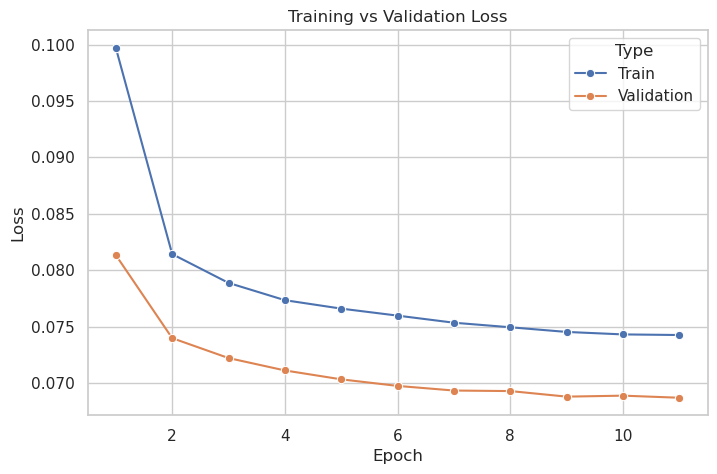

In [5]:
plot_losses(train_loss, valid_loss)